# Consistency between the dataset underpinning the Copernicus Interactive Climate Atlas and its origins: Multiple origin datasets

**Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch.**

Production date: DD-MM-YYYY

Dataset version: 2.0.

Produced by: C3S2_521 contract.

## 🌍 Use case: Retrieving climate indicators from the Copernicus Interactive Climate Atlas

## ❓ Quality assessment question
* **Are the climate indicators in the dataset underpinning the Copernicus Interactive Climate Atlas consistent with their origin datasets?**
* **Can the dataset underpinning the Copernicus Interactive Climate Atlas be reproduced from its origin datasets?**

The [_Copernicus Interactive Climate Atlas_](https://atlas.climate.copernicus.eu/atlas), or _Atlas_ for short, is a C3S web application providing an easy-to-access tool for exploring climate projections, reanalyses, and observational data [[Guti24](https://doi.org/10.21957/ah52ufc369)].
Version 2.0 of the application allows the user to interact with 12 datasets:

| Type               | Dataset       |
|--------------------|---------------|
| Climate Projection | CMIP6         |
| Climate Projection | CMIP5         |
| Climate Projection | CORDEX-CORE   |
| Climate Projection | CORDEX-EUR-11 |
| Reanalysis         | ERA5          |
| Reanalysis         | ERA5-Land     |
| Reanalysis         | ORAS5         |
| Reanalysis         | CERRA         |
| Observations       | E-OBS         |
| Observations       | BERKEARTH     |
| Observations       | CPC           |
| Observations       | SST-CCI       |

These datasets are provided through an intermediary dataset, the [_Gridded dataset underpinning the Copernicus Interactive Climate Atlas_](https://doi.org/10.24381/cds.h35hb680) or _Atlas dataset_ for short [[AtlasData](https://doi.org/10.24381/cds.h35hb680)].
Compared to their origins, the versions of the climate datasets within the Atlas dataset have been processed following the workflow in Figure {numref}`{number} <multi-origin-c3s-atlas_consistency_q03_workflow-fig>`.

```{figure} attachment:atlas_dataset_workflow.png
---
height: 360px
name: multi-origin-c3s-atlas_consistency_q03_workflow-fig
---
Schematic representation of the workflow for the production of the Atlas dataset from its origin datasets, from the [User-tools for the C3S Atlas](https://ecmwf-projects.github.io/c3s-atlas/chapter01.html).
```

Because a wide range of users interact with climate data through the Atlas application, it is crucial that the underpinning dataset represent its origins correctly.
In other words, the Atlas dataset must be consistent with and reproducible from its origins.
Here, we assess this consistency and reproducibility by comparing climate indicators retrieved from the Atlas dataset with their equivalents calculated from the origin dataset, mirroring the workflow from Figure {numref}`{number} <multi-origin-c3s-atlas_consistency_q03_workflow-fig>`.
While a full analysis and reproduction of every record within the Atlas dataset is outside the scope of quality assessment
(and would require high-performance computing infrastructure),
a case study with a narrower scope probes these quality attributes of the dataset
and can be a jumping-off point for further analysis by the reader.

This notebook is part of a series:
| Notebook | Contents |
|---|---|
| [](./derived_multi-origin-c3s-atlas_consistency_q01) | Comparison between Atlas dataset and one origin dataset (CMIP6) for one indicator (`tx35`), including detailed setup. |
| [](./derived_multi-origin-c3s-atlas_consistency_q02) | Comparison between Atlas dataset and one origin dataset (CMIP6) for multiple indicators. |
| [](./derived_multi-origin-c3s-atlas_consistency_q03) | Comparison between Atlas dataset and multiple origin datasets for one indicator. |
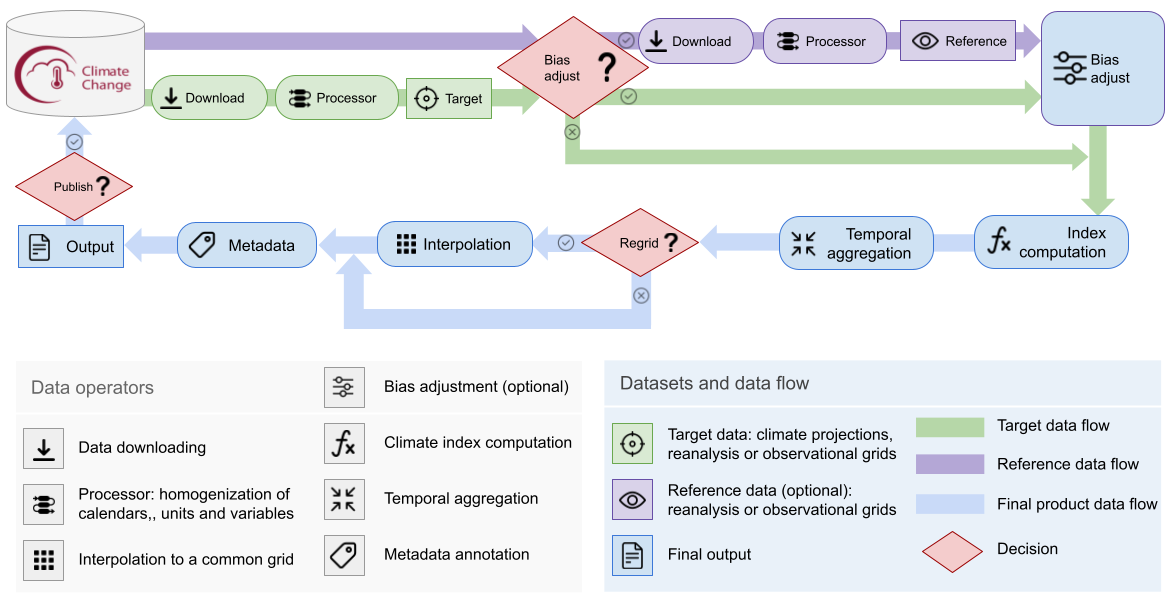

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Finding 1: will be a statement on the findings regarding the consistency 
* Finding 2
* Finding 3
* etc
```

## 📋 Methodology
This quality assessment tests the consistency between climate indicators retrieved from the [_Gridded dataset underpinning the Copernicus Interactive Climate Atlas_](https://doi.org/10.24381/cds.h35hb680) [[AtlasData](https://doi.org/10.24381/cds.h35hb680)] and their equivalents calculated from the origin datasets,
as well as the reproducibility of said dataset.

This notebook probes the consistency between the Atlas dataset and multiple origin datasets at the same time.
Due to differences in scope (e.g. atmosphere / land / sea), not every indicator is available in every origin dataset or its Atlas derivative.
Furthermore, some origin datasets are historical while others are future projections.
For this reason, we will examine the following indicators in the following origin datasets:

| Type               | Dataset       | Indicator |
|--------------------|---------------|-----------|
| Climate Projection | CMIP6         | _Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C_ (`tx35`)
| Climate Projection | CMIP5         | _Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C_ (`tx35`)
| Climate Projection | CORDEX-CORE   | _Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C_ (`tx35`)
| Climate Projection | CORDEX-EUR-11 | _Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C_ (`tx35`)
| Reanalysis         | ERA5          | _Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C_ (`tx35`)
| Reanalysis         | ERA5-Land     | _Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C_ (`tx35`)
| Reanalysis         | ORAS5         | Mean sea surface temperature
| Reanalysis         | CERRA         | _Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C_ (`tx35`)
| Observations       | E-OBS         | _Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C_ (`tx35`)
| Observations       | BERKEARTH     | _Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C_ (`tx35`)
| Observations       | CPC           | Mean of daily accumulated precipitation
| Observations       | SST-CCI       | Mean sea surface temperature

The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](section-codesetup)**
 * Install User-tools for the C3S Atlas.
 * Import all required libraries.
 * Definition of helper functions.

**[](section-origin)**
 * Download data from the origin dataset(s).
 * Homogenise data.
 * Calculate indicator(s).
 * Interpolate to a common and regular grid.

**[](section-atlas)**
 * Download data from the Atlas dataset.

**[](section-results)**
 * Consistency: Compare the Atlas and reproduced datasets on native grids.
 * Reproducibility: Compare the Atlas and reproduced datasets on the Atlas grid.

## 📈 Analysis and results

(section-codesetup)=
### 1. Code setup
```{note}
This notebook uses [earthkit](https://github.com/ecmwf/earthkit) for 
downloading ([earthkit-data](https://github.com/ecmwf/earthkit-data)) 
and visualising ([earthkit-plots](https://github.com/ecmwf/earthkit-plots)) data.
Because earthkit is in active development, some functionality may change after this notebook is published.
If any part of the code stops functioning, please raise an issue on our GitHub repository so it can be fixed.
```

#### Install the User-tools for the C3S Atlas
This notebook uses the [User-tools for the C3S Atlas](https://github.com/ecmwf-projects/c3s-atlas), which can be installed from GitHub using `pip`.
For convenience, the following cell can do this from within the notebook.
Further details and alternative options for installing this library are available in its [documentation](https://github.com/ecmwf-projects/c3s-atlas?tab=readme-ov-file#requirements).

In [1]:
!pip install git+https://github.com/ecmwf-projects/c3s-atlas.git

  Cloning https://github.com/ecmwf-projects/c3s-atlas.git to /tmp/pip-req-build-k6i78ana
  Running command git clone --filter=blob:none --quiet https://github.com/ecmwf-projects/c3s-atlas.git /tmp/pip-req-build-k6i78ana
  Resolved https://github.com/ecmwf-projects/c3s-atlas.git to commit 80256810cb81aa78ab53033479e08cff6a8add44
  Preparing metadata (setup.py) ... done


#### Import required libraries
In this section, we import all the relevant packages needed for running the notebook.

In [2]:
# works
# Input / Output
from pathlib import Path
import earthkit.data as ekd

# General data handling
import numpy as np
import pandas as pd
import xarray as xr
from functools import partial

# Data pre-processing
from c3s_atlas.fixers import apply_fixers
import c3s_atlas.interpolation as xesmfCICA

# Climate indicators
import xclim
xclim.set_options(cf_compliance="log")  # Mute warnings
import c3s_atlas.indexes
from c3s_atlas.units import VALID_UNITS

# Visualisation
import earthkit.plots as ekp
from earthkit.plots.styles import Style
import matplotlib.pyplot as plt
plt.rcParams["grid.linestyle"] = "--"
from tqdm import tqdm  # Progress bars

# Visualisation in Jupyter book -- automatically ignored otherwise
try:
    from myst_nb import glue
except ImportError:
    glue = None

/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


#### Define indicators

In [3]:
# works
def cal_tx35(ds):
    """ Monthly count of days with maximum near-surface (2-metre) temperature above 35 °C """
    ds_tx35 = xclim.indices.tx_days_above(ds['tasmax'], thresh='35.0 degC', freq='MS', op='>').to_dataset(name='tx35')
    return ds_tx35

def cal_r01(ds):
    """ Monthly count of days with daily accumulated precipitation of liquid water equivalent from all phases above 1 mm """
    pr_flux = ds['pr'].copy().assign_attrs(units = 'mm/day')
    per0 = xr.zeros_like(pr_flux).assign_attrs(units='mm/day')
    ds_r01 = xclim.indices.days_over_precip_thresh(pr_flux, per0, thresh='1 mm/day', freq='MS', bootstrap=False, op='>').to_dataset(name='r01')
    return ds_r01

def cal_sst(ds):
    """ Monthly mean temperature of sea water near the surface """
    ds_sst = ds['sst'].resample(time='MS').mean().to_dataset(name='sst')
    return ds_sst

In [4]:
# works
# Styles for indicators
n_diff = 5  # Levels in difference charts

_style_monthly_days      = {"vmin": 0,     "vmax": 30,    "extend": "neither"}
_style_monthly_days_diff = {"vmin": -2.5,  "vmax": 2.5,   "extend": "both"}

# Temperature day indices
_style_tx35      = _style_monthly_days      | {"cmap": plt.cm.Oranges.resampled(10)}
_style_tx35_diff = _style_monthly_days_diff | {"cmap": plt.cm.RdBu_r.resampled(n_diff)}


# Individual styles
# Set up like this so they can still be edited individually
styles = {
    "tx35": Style(**_style_tx35),       "tx35_diff": Style(**_style_tx35_diff),
}

# Apply general settings
for style in styles.values():
    style.normalize = False

#### Helper functions

##### General

In [5]:
# works
# Type hints
from typing import Iterable, Optional
from earthkit.plots.geo.domains import Domain
AnyDomain = (Domain | str)

##### Data (pre-)processing

In [6]:
# works
# Download Atlas data
def select_model_from_atlas_dataset(data: xr.Dataset, model: str) -> xr.Dataset:
    """ Select only data for the given model. """
    # Ensure the model ID is provided in the right format
    model_id = model.replace("_", "-").lower()

    # Find the corresponding model ID in the list of models
    # This cannot use .sel because the coordinate is not indexed
    select_member = [str(mem) for mem in data.member_id.values if model_id in mem.replace("_", "-").lower()][0]

    # Find the corresponding data and return those
    member_ind = np.where(data.member_id == select_member)[0]
    data_member = data.sel(member=member_ind).squeeze("member")

    return data_member

# Select (multiple) years in a dataset
def select_years_in_dataset(data: xr.Dataset, years: list[int]) -> xr.Dataset:
    """ Select only data for the given year(s). """
    years_int = [int(y) for y in years]
    return data.sel(time=data.time.dt.year.isin(years_int))

def _download_atlas_single(request: Iterable[dict], model: Optional[str] = None) -> xr.Dataset:
    """ Helper function for download_atlas_data_oneyear_onemember; download and process a single Atlas request. """
    # Download data
    ATLAS_ID = "multi-origin-c3s-atlas"
    ds = ekd.from_source("cds", ATLAS_ID, request)
    data = ds.to_xarray(compat="equals")
    
    # Drop "bnds" variables which can mess with merge later on
    bnds = [var for var in data.data_vars if var.endswith("_bnds")]
    data = data.drop_vars(bnds)
    data
    if request['origin'] == "cmip5":
        data = select_model_from_atlas_dataset(data, "access1_0")

    if request['origin'] == "cmip6":
        data = select_model_from_atlas_dataset(data, "access_cm2")

    if request['origin'] == "cordex_core":
        data = select_model_from_atlas_dataset(data, "NCC_NorESM1-M_REMO")

    if request['origin'] in ("cmip5", "cmip6", "cordex_core"):
        data = select_years_in_dataset(data, YEARS_FUTURE)    
    if request['origin'] in ("e_obs", "era5", "cerra", "in_situ_temperature"):
        data = select_years_in_dataset(data, YEARS_HISTORICAL)   
        
    return data

In [7]:
# works
# Create requests for multiple daily / monthly variables
def create_requests_for_origins(main_request: dict, origins: Iterable[str]) -> dict:
    """ Given a `main_request`, add all missing entries for every origin. """
    requests = [(main_request | req) for req in origins]
    return requests

In [8]:
# works
def create_requests_for_months(main_request: dict, month_req: dict) -> dict:
    """ Given a `main_request`, add all the monthly entery. """
    requests = (main_request | month_req) #for req in month_requests]
    return requests


In [9]:
# works
# Homogenisation of origin dataset
def homogenise(ds: xr.Dataset, var_name: str, project_id: str) -> xr.Dataset:
    """ Homogenise a dataset `ds` for one variable `var_name` """
    var_mapping = {
                "dataset_variable": {var_name: "data"},
                "aggregation": {"data": "mean"},
        }
    data = apply_fixers(ds, var_name, project_id, var_mapping)
    return data

In [10]:
# works
# Interpolation from native grid to Atlas grid
def interpolation(ds: xr.Dataset, var_name: str) -> xr.Dataset:
    """ Interpolates a dataset, ds, for one variable, var_name """
    int_attr = {'interpolation_method': 'conservative_normed', 
                'lats': np.arange(-89.5, 90.5, 1),
                'lons': np.arange(-179.5, 180.5, 1),
                'var_name': var_name,
    }
    INTER = xesmfCICA.Interpolator(int_attr)
    ds_interp = INTER(ds)
    return ds_interp


##### Visualisations

In [11]:
# works
# Select one month in multiple datasets
def select_month_in_multiple_datasets(*data: xr.Dataset, month: int=8) -> list[xr.Dataset]:
    """ Select only data for the given month, in any year. """
    data_month = [d.groupby("time.month")[month] for d in data]
    return data_month

def _spatial_plot_append_subplots(fig: ekp.Figure, *data: xr.Dataset, domain: Optional[AnyDomain]=None, **kwargs) -> list[ekp.Subplot]:
    """ Plot any number of datasets into new subplots in an existing earthkit figure. """
    # Create subplots
    subplots = [fig.add_map(domain=domain) for d in data]

    # Plot
    for subplot, d in zip(subplots, data):
        subplot.grid_cells(d, **kwargs)

    return subplots

(section-origin)=
### 2. Calculate indicators from the origin datasets

#### Download data
This notebook uses [earthkit-data](https://github.com/ecmwf/earthkit-data) to download files from the CDS.
If you intend to run this notebook multiple times, it is highly recommended that you [enable caching](https://earthkit-data.readthedocs.io/en/latest/guide/caching.html) to prevent having to download the same files multiple times.

The first step is to define the parameters that will be shared between the downloads of the various origin datasets and the Atlas dataset (in the [next section](section-atlas)).
Next,
for each individual origin dataset,
the request to download the corresponding data from the CDS is defined.

In [12]:
# works
# General setup
YEARS_HISTORICAL = ["2010"]
YEARS_FUTURE = ["2080"]
MONTHS = [f"{month:02d}" for month in range(1, 13)]
DAYS = [f"{day:02d}" for day in range(1, 32)]

In [13]:
# works
# Download CMIP5 data
CMIP5_ID = "projections-cmip5-daily-single-levels"
CMIP5_MODEL = "access1_0"
request_CMIP5 = {
    "experiment": "rcp_8_5",
    "variable": ["maximum_2m_temperature_in_the_last_24_hours"],
    "model": CMIP5_MODEL,
    "ensemble_member": "r1i1p1",
    "period": ["20560101-20801231"]
}

ds_CMIP5 = ekd.from_source("cds", CMIP5_ID, request_CMIP5)
data_CMIP5 = ds_CMIP5.to_xarray()
data_CMIP5

2025-10-01 16:38:36,180 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-10-01 16:38:36,182 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


<xarray.Dataset> Size: 1GB
Dimensions:    (time: 9132, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 73kB 2056-01-01T12:00:00 ... 2080-12-31T...
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 146kB dask.array<chunksize=(9132, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 2kB dask.array<chunksize=(145, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
    tasmax     (time, lat, lon) float32 1GB dask.array<chunksize=(9132, 145, 192), meta=np.ndarray>
Attributes: (12/28)
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institute_id:           CSIRO-BOM
    experiment_id:          rcp85
    source:                 ACCESS1-0 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    model_id:               ACCESS1-0
    forcing:                GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4...
    ...                     ...
    table_id:               Table day (01 February 2012) b6353e9919862612c81d...
    title:                  ACCESS1-0 model output prepared for CMIP5 RCP8.5
    parent_experiment:      historical
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.8.0

In [14]:
# works
# Download CMIP6 data
CMIP6_ID = "projections-cmip6"
CMIP6_MODEL = "access_cm2"
request_CMIP6 = {
    "temporal_resolution": "daily",
    "experiment": "ssp5_8_5",
    "model": CMIP6_MODEL,
    "variable": ["daily_maximum_near_surface_air_temperature"],
    "year": YEARS_FUTURE,
    "month": MONTHS,  
    "day": DAYS,
}

ds_CMIP6 = ekd.from_source("cds", CMIP6_ID, request_CMIP6)
data_CMIP6 = ds_CMIP6.to_xarray()
data_CMIP6

2025-10-01 16:38:38,293 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-10-01 16:38:38,294 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
Unknown file type, no reader available. path=/tmp/earthkit-data-nr2/cds-d8c4f864a8b41e393fe23f5694bd9fa6f2a154249e1ea7eba118a624d6e58ffe.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x0b>\x00\x00\x03"\x08\x02\x00\x00\x00\x9a~`*\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddw' content_type=None


<xarray.Dataset> Size: 40MB
Dimensions:    (time: 366, bnds: 2, lat: 144, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2080-01-01T12:00:00 ... 2080-12-31T1...
  * lat        (lat) float64 1kB -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * lon        (lon) float64 2kB 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 2kB dask.array<chunksize=(144, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
    tasmax     (time, lat, lon) float32 40MB dask.array<chunksize=(1, 144, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    creation_date:          2019-11-08T10:49:05Z
    ...                     ...
    variable_id:            tasmax
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/b20bdc82-6885-4464-b154-007da646461f
    license:                CMIP6 model data produced by CSIRO is licensed un...

In [15]:
# works
# Download CORDEX EUR 11 data
CORDEX_EUR_11_ID = "projections-cordex-domains-single-levels"
CORDEX_EUR_11_MODEL = "NCC_NorESM1-M_REMO"
request_CORDEX_EUR_11 = {
    "domain": "europe",
    "experiment": "rcp_8_5",
    "horizontal_resolution": "0_11_degree_x_0_11_degree",
    "temporal_resolution": "daily_mean",
    "variable": ["maximum_2m_temperature_in_the_last_24_hours"],
    "gcm_model": "ncc_noresm1_m",
    "rcm_model": "gerics_remo2015",
    "ensemble_member": "r1i1p1",
    "start_year": ["2076"],
    "end_year": ["2080"]
}

ds_CORDEX_EUR_11 = ekd.from_source("cds", CORDEX_EUR_11_ID, request_CORDEX_EUR_11)
data_CORDEX_EUR_11 = ds_CORDEX_EUR_11.to_xarray()
data_CORDEX_EUR_11

2025-10-01 16:38:38,574 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-10-01 16:38:38,576 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


<xarray.Dataset> Size: 1GB
Dimensions:                     (time: 1827, bnds: 2, rlat: 412, rlon: 424,
                                 vertices: 4)
Coordinates:
  * time                        (time) datetime64[ns] 15kB 2076-01-01T12:00:0...
  * rlat                        (rlat) float64 3kB -23.38 -23.27 ... 21.72 21.84
  * rlon                        (rlon) float64 3kB -28.38 -28.27 ... 18.04 18.16
    lat                         (rlat, rlon) float32 699kB dask.array<chunksize=(412, 424), meta=np.ndarray>
    lon                         (rlat, rlon) float32 699kB dask.array<chunksize=(412, 424), meta=np.ndarray>
    height                      float64 8B ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds                   (time, bnds) datetime64[ns] 29kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    rotated_latitude_longitude  int32 4B ...
    lat_vertices                (rlat, rlon, vertices) float32 3MB dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    lon_vertices                (rlat, rlon, vertices) float32 3MB dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    tasmax                      (time, rlat, rlon) float32 1GB dask.array<chunksize=(1, 412, 424), meta=np.ndarray>
Attributes: (12/35)
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    institute_id:                   GERICS
    experiment_id:                  rcp85
    source:                         GERICS-REMO2015
    model_id:                       GERICS-REMO2015
    forcing:                        N/A
    ...                             ...
    parent_experiment:              N/A
    modeling_realm:                 atmos
    realization:                    1
    cmor_version:                   2.9.1
    tracking_id:                    hdl:21.14103/c3a4e035-9dcd-429f-a86d-8d53...
    c3s_disclaimer:                 This data has been produced in the contex...

In [16]:
# works
# Download E-OBS data
E_OBS_ID = "insitu-gridded-observations-europe"
request_E_OBS = {
    "product_type": "ensemble_mean",
    "variable": ["maximum_temperature"],
    "grid_resolution": "0_25deg",
    "period": "full_period",
    "version": ["30_0e"]
}

ds_E_OBS = ekd.from_source("cds", E_OBS_ID, request_E_OBS)
data_E_OBS = ds_E_OBS.to_xarray()

# preprocessing for homogenisation 
data_E_OBS = data_E_OBS.rename({"tx": "tasmax"})

data_E_OBS

2025-10-01 16:38:38,902 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-10-01 16:38:38,903 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


<xarray.Dataset> Size: 10GB
Dimensions:    (time: 27210, latitude: 201, longitude: 464)
Coordinates:
  * latitude   (latitude) float64 2kB 25.38 25.62 25.88 ... 74.88 75.12 75.38
  * longitude  (longitude) float64 4kB -40.38 -40.12 -39.88 ... 75.12 75.38
  * time       (time) datetime64[ns] 218kB 1950-01-01 1950-01-02 ... 2024-06-30
Data variables:
    tasmax     (time, latitude, longitude) float32 10GB dask.array<chunksize=(1, 201, 464), meta=np.ndarray>
Attributes:
    E-OBS_version:  30.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Aug 30 12:47:29 2024: ncks --no-abc -d time,0,27209 /...
    NCO:            netCDF Operators version 5.1.8 (Homepage = http://nco.sf....

In [17]:
# works
# Download ERA data
ERA5_ID = "reanalysis-era5-single-levels"
request_ERA5 = {
    "product_type": ["reanalysis"],
    "variable": ["maximum_2m_temperature_since_previous_post_processing"],
    "year": YEARS_HISTORICAL,
    "month": MONTHS,  
    "day": DAYS,
    "data_format": "netcdf",
    "download_format": "unarchived",
}

ds_ERA5 = ekd.from_source("cds", ERA5_ID, request_ERA5)
data_ERA5 = ds_ERA5.to_xarray()

# preprocessing for homogenisation 
data_ERA5 = data_ERA5.rename({"valid_time": "time"})   
data_ERA5 = data_ERA5.rename({"mx2t": "tasmax"})  

data_ERA5

2025-10-01 16:38:39,339 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-10-01 16:38:39,340 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


<xarray.Dataset> Size: 2GB
Dimensions:    (time: 365, latitude: 721, longitude: 1440)
Coordinates:
    number     int64 8B ...
  * time       (time) datetime64[ns] 3kB 2010-01-01T12:00:00 ... 2010-12-31T1...
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver     (time) <U4 6kB dask.array<chunksize=(365,), meta=np.ndarray>
Data variables:
    tasmax     (time, latitude, longitude) float32 2GB dask.array<chunksize=(73, 145, 288), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-30T08:24 GRIB to CDM+CF via cfgrib-0.9.1...

In [18]:
# works
# Download ERA-Land data
ERA5_Land_ID = "derived-era5-land-daily-statistics"  
request_ERA5_Land = {
    "variable": ["2m_temperature"],
    "year": YEARS_HISTORICAL,
    "day": DAYS,
    "daily_statistic": "daily_maximum",
    "time_zone": "utc+00:00",
    "frequency": "1_hourly",
}

# Do monthly request as yearly request exceeds CDS limits
request_month_ERA5_Land = [{"month": [f"{month:02d}"]} for month in range(1, 13)]    
requests_monthly_era5_land = [create_requests_for_months(request_ERA5_Land, month) for month in request_month_ERA5_Land]

# Combinbe 
ds_ERA5_Land = ekd.from_source("cds", ERA5_Land_ID, *requests_monthly_era5_land)
data_ERA5_Land = ds_ERA5_Land.to_xarray()

# preprocessing for homogenisation 
data_ERA5_Land = data_ERA5_Land.rename({"valid_time": "time"}) 
data_ERA5_Land = data_ERA5_Land.rename({"t2m": "tasmax"})  
data_ERA5_Land

2025-10-01 16:38:39,585 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-10-01 16:38:39,587 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 149.85it/s]


<xarray.Dataset> Size: 9GB
Dimensions:    (time: 365, latitude: 1801, longitude: 3600)
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 14kB 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude  (longitude) float64 29kB 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9
  * time       (time) datetime64[ns] 3kB 2010-01-01 2010-01-02 ... 2010-12-31
Data variables:
    tasmax     (time, latitude, longitude) float32 9GB dask.array<chunksize=(8, 451, 900), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-30T12:23 GRIB to CDM+CF via cfgrib-0.9.1...

In [19]:
# works
# Download CERRA data
CERRA_ID = "reanalysis-cerra-single-levels"
request_CERRA = {
    "variable": ["maximum_2m_temperature_since_previous_post_processing"],
    "level_type": "surface_or_atmosphere",
    "data_type": ["reanalysis"],
    "product_type": "forecast",
    "year": YEARS_HISTORICAL,
    "month": MONTHS,
    "day": DAYS,
    "time": [
        "00:00", "03:00", "06:00",
        "09:00", "12:00", "15:00",
        "18:00", "21:00"
    ],
    "leadtime_hour": ["1"],
    "data_format": "netcdf",
}

ds_CERRA = ekd.from_source("cds", CERRA_ID, request_CERRA)
data_CERRA = ds_CERRA.to_xarray()

# preprocessing for homogenisation 
data_CERRA = data_CERRA.rename({"valid_time": "time"})   
data_CERRA = data_CERRA.rename({"mx2t": "tasmax"})   

data_CERRA

2025-10-01 16:38:40,214 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-10-01 16:38:40,215 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


<xarray.Dataset> Size: 13GB
Dimensions:    (time: 2920, y: 1069, x: 1069)
Coordinates:
  * time       (time) datetime64[ns] 23kB 2010-01-01T01:00:00 ... 2010-12-31T...
    latitude   (y, x) float64 9MB dask.array<chunksize=(1069, 1069), meta=np.ndarray>
    longitude  (y, x) float64 9MB dask.array<chunksize=(1069, 1069), meta=np.ndarray>
    expver     (time) <U4 47kB dask.array<chunksize=(2920,), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    tasmax     (time, y, x) float32 13GB dask.array<chunksize=(292, 107, 107), meta=np.ndarray>
Attributes:
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Norrkoping
    history:                 2025-09-30T14:12 GRIB to CDM+CF via cfgrib-0.9.1...

In [20]:
# works
# Download BERKEARTH data
BERKEARTH_ID = "insitu-gridded-observations-global-and-regional"
request_BERKEARTH = {
    "origin": "berkearth",
    "region": "global",
    "variable": ["temperature_anomaly"],
    "statistic": ["maximum"],
    "time_aggregation": "daily",
    "horizontal_aggregation": ["1_x_1"],
    "year": ["2019"],
    "version": ["v1_0"]
}

ds_BERKEARTH = ekd.from_source("cds", BERKEARTH_ID, request_BERKEARTH)
data_BERKEARTH = ds_BERKEARTH.to_xarray()

# preprocessing for homogenisation 
data_BERKEARTH["tasmax"].attrs["units"] = "Celsius"

data_BERKEARTH

2025-10-01 16:38:40,490 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-10-01 16:38:40,491 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


<xarray.Dataset> Size: 95MB
Dimensions:    (time: 365, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2019-01-01 2019-01-02 ... 2019-12-31
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Data variables:
    tasmax     (time, latitude, longitude) float32 95MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/21)
    CDI:                        Climate Data Interface version 1.9.10 (https:...
    institution:                Berkeley Earth Surface Temperature Project
    Conventions:                Berkeley Earth Internal Convention (based on ...
    title:                      Gridded Berkeley Earth Surface Temperature An...
    source_history:             14-Sep-2020 16:15:39
    comment:                    This file contains surface temperature anomal...
    ...                         ...
    geospatial_lon_resolution:  1.0
    climexp_url:                https://climexp.knmi.nl/select.cgi?berkeley_t...
    history:                    Fri Jun 18 07:44:32 2021: cdo -O -splityear /...
    time_coverage_start:        1880-01-01 00:00:00
    time_coverage_end:          2019-12-31 00:00:00
    CDO:                        Climate Data Operators version 1.9.10 (https:...

In [21]:
# works
# Download ORAS5 data
ORAS5_ID = "reanalysis-oras5"
request_ORAS5 = {
    "product_type": ["operational"],
    "vertical_resolution": "single_level",
    "variable": ["sea_surface_temperature"],
    "year": ["2020"],
    "month": MONTHS,
}

ds_ORAS5 = ekd.from_source("cds", ORAS5_ID, request_ORAS5)
data_ORAS5 = ds_ORAS5.to_xarray()

# preprocessing for homogenisation 
data_ORAS5 = data_ORAS5.rename({"sosstsst": "sst"})   
data_ORAS5["sst"].attrs["units"] = "Celsius"    

data_ORAS5

2025-10-01 16:38:40,678 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-10-01 16:38:40,679 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


<xarray.Dataset> Size: 82MB
Dimensions:            (time_counter: 12, y: 1021, x: 1442, bnds: 2)
Coordinates:
    nav_lat            (y, x) float32 6MB dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 6MB dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter       (time_counter) datetime64[ns] 96B 2020-01-16T12:00:00 ...
Dimensions without coordinates: y, x, bnds
Data variables:
    sst                (time_counter, y, x) float32 71MB dask.array<chunksize=(1, 1021, 1442), meta=np.ndarray>
    time_counter_bnds  (time_counter, bnds) datetime64[ns] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    NCO:          netCDF Operators version 4.9.7 (Homepage = http://nco.sf.ne...
    title:        Monthly mean 2D Sea Surface fields
    source:       ORAS5 - backward extension (ECMWF)
    institution:  European Centre for Medium-Range Weather Forecasts (ECMWF) ...
    reference:    https://www.ecmwf.int/en/research/climate-reanalysis/ocean-...

In [ ]:
# WIP
# Download SST_CCI data  
SST_CCI_ID = "satellite-sea-surface-temperature-ensemble-product"

request_main_SST_CCI = {
    "variable": "all",
    "year": ["2010"]
}

requests_daily_SST_CCI = [
    {"month": [f"{month:02d}"], "day": [f"{day:02d}"]}
    for month in range(1, 13)
    for day in range(1, 32)
]


def download_select_data(request: dict, variable: str):
    """ Given a `request`, download the data, and select the required `variable`. """
    ds_SST_CCI = ekd.from_source("cds", SST_CCI_ID, *request)#
    ds_SST_CCI = ds_SST_CCI.to_xarray()
    ds_SST_CCI_sst = ds_SST_CCI[variable]
    return ds_SST_CCI_sst

def create_requests_for_daily(main_request: dict, daily_req: dict, variable: str) -> dict:
    """ Given a `main_request`, add all the `daily_req` (consists of day and month value). """
    requests = (main_request | daily_req) #for req in month_requests]
    return requests

requests_full_daily_SST_CCI = [create_requests_for_days(request_main_SST_CCI, daily_request) for daily_request in requests_daily_SST_CCI]

ds_SST_CCI = download_select_data(requests_full_daily_SST_CCI, "analysed_sst")

# # preprocessing for homogenisation 
# ds_SST_CCI = ds_SST_CCI.rename({"analysed_sst": "sst"}) 
# ds_SST_CCI["sst"].attrs["units"] = "Kelvin"  

# data_SST_CCI_new

In [23]:
# works
# Download CPC data 
CPC_ID = "insitu-gridded-observations-global-and-regional"
request_CPC = {
    "origin": "cpc",
    "region": "global",
    "variable": ["precipitation"],
    "time_aggregation": "daily",
    "horizontal_aggregation": ["0_5_x_0_5"],
    "year": YEARS_HISTORICAL,
    "version": ["v1_0"]
}

ds_CPC = ekd.from_source("cds", CPC_ID, request_CPC)
data_CPC = ds_CPC.to_xarray()

# preprocessing for homogenisation 
data_CPC["pr"].attrs["units"] = "mm day**-1"  
data_CPC

2025-10-01 16:38:42,398 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-10-01 16:38:42,400 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


<xarray.Dataset> Size: 757MB
Dimensions:  (time: 365, lat: 360, lon: 720)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2010-01-01T12:00:00 ... 2010-12-31T12:...
  * lon      (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Data variables:
    pr       (time, lat, lon) float64 757MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/19)
    CDI:                        Climate Data Interface version 1.9.10 (https:...
    institution:                NOAA/NCEP/CPC (converted to netcdf at KNMI)
    Conventions:                CF-1.4
    NCO:                        netCDF Operators version 4.9.0 (Homepage = ht...
    title:                      CPC unified (gauge-based) precipitation
    source_url:                 ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_UNI_PR...
    ...                         ...
    geospatial_lon_resolution:  0.5
    climexp_url:                https://climexp.knmi.nl/select.cgi?prcp_cpc_d...
    history:                    Fri Jun 18 07:52:31 2021: cdo -O -splityear /...
    time_coverage_start:        1979-01-01 12:00:00
    time_coverage_end:          2021-12-31 12:00:00
    CDO:                        Climate Data Operators version 1.9.10 (https:...

#### Homogenise data
One of the steps in the Atlas dataset production chain is homogenisation, i.e. ensuring consistency between data from different origin datasets.
This homogenisation is implemented in the [User-tools for the C3S Atlas](https://github.com/ecmwf-projects/c3s-atlas/tree/main/c3s_atlas), specifically the `c3s_atlas.fixers.apply_fixers` function.
The following changes are applied:

- The names of the spatial coordinates are standardised to `[lon, lat]`.
- Longitude is converted from `[0...360]` to `[-180...180]` format.
- The time coordinate is standardised to the CF standard calendar.
- Variable units are standardised (e.g. °C for temperature).
- Variables are resampled / aggregated to the required temporal resolution.

The homogenisation is applied in the following code cell.
The `apply_fixers` function describes the different homogenisation steps as it applies them;
this can be read by expanding the following cell outputs.

In [24]:
# NEEDS EXPANDING
# currently works but needs the final datasets (CERRA and ERA5_LAND) to be added
datasets_tx35 = {
    "CMIP5": data_CMIP5,
    "CMIP6": data_CMIP6,
    "CORDEX_EUR_11": data_CORDEX_EUR_11,
    "E_OBS": data_E_OBS,
    "ERA5": data_ERA5,
    "ERA5_Land": data_ERA5_Land,
    "BERKEARTH": data_BERKEARTH,
}
#  "CERRA": data_CERRA, }      

datasets_tx35_homogenised = {key: homogenise(ds, "tasmax", key) for key, ds in datasets_tx35.items()}
datasets_tx35_homogenised

2025-10-01 16:38:42,459 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2025-10-01 16:38:42,473 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 1GB
Dimensions:    (time: 9132, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 73kB 2056-01-01T12:00:00 ... 2080-12-31T...
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 146kB dask.array<chunksize=(9132, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 2kB dask.array<chunksize=(145, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
    tasmax     (time, lat, lon) float32 1GB dask.array<chunksize=(9132, 145, 192), meta=np.ndarray>
Attributes: (12/28)


{'CMIP5': <xarray.Dataset> Size: 1GB
 Dimensions:  (lat: 145, lon: 192, time: 9132)
 Coordinates:
   * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
   * lon      (lon) float64 2kB -178.1 -176.2 -174.4 -172.5 ... 176.2 178.1 180.0
   * time     (time) datetime64[ns] 73kB 2056-01-01 2056-01-02 ... 2080-12-31
     height   float64 8B 2.0
 Data variables:
     tasmax   (time, lat, lon) float32 1GB dask.array<chunksize=(9132, 145, 192), meta=np.ndarray>
 Attributes: (12/28)
     institution:            CSIRO (Commonwealth Scientific and Industrial Res...
     institute_id:           CSIRO-BOM
     experiment_id:          rcp85
     source:                 ACCESS1-0 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
     model_id:               ACCESS1-0
     forcing:                GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4...
     ...                     ...
     table_id:               Table day (01 February 2012) b6353e9919862612c81d...
     title:             

In [25]:
# NEEDS EXPANDING
# currently works but needs the final dataset (SST_CCI) to be added
datasets_sst = {
    "ORAS5": data_ORAS5,
    
}    
#"SST_CCI": data_SST_CCI,
datasets_sst_homogenised = {key: homogenise(ds, "sst", key) for key, ds in datasets_sst.items()}
datasets_sst_homogenised

2025-10-01 16:38:44,961 — Homogenization-fixers — INFO — Fixing coordinates names: {'nav_lon': 'lon', 'nav_lat': 'lat'}
2025-10-01 16:38:44,990 — UNITS_TRANSFORM — INFO — The dataset sst units are already in the correct magnitude
2025-10-01 16:38:45,028 — Homogenization-fixers — INFO — The dataset is in daily or monthly resolution, we don't need to resample it from hourly frequency


{'ORAS5': <xarray.Dataset> Size: 82MB
 Dimensions:  (time: 12, y: 1021, x: 1442)
 Coordinates:
     lat      (y, x) float32 6MB dask.array<chunksize=(1021, 1442), meta=np.ndarray>
     lon      (y, x) float32 6MB dask.array<chunksize=(1021, 1442), meta=np.ndarray>
   * time     (time) datetime64[ns] 96B 2020-01-01 2020-02-01 ... 2020-12-01
     height   float64 8B 2.0
   * x        (x) int64 12kB 0 1 2 3 4 5 6 ... 1435 1436 1437 1438 1439 1440 1441
   * y        (y) int64 8kB 0 1 2 3 4 5 6 ... 1014 1015 1016 1017 1018 1019 1020
 Data variables:
     sst      (time, y, x) float32 71MB dask.array<chunksize=(1, 1021, 1442), meta=np.ndarray>
 Attributes:
     Conventions:  CF-1.6
     NCO:          netCDF Operators version 4.9.7 (Homepage = http://nco.sf.ne...
     title:        Monthly mean 2D Sea Surface fields
     source:       ORAS5 - backward extension (ECMWF)
     institution:  European Centre for Medium-Range Weather Forecasts (ECMWF) ...
     reference:    https://www.ecmwf.int/en

In [26]:
# works
datasets_r01 = {
    "CPC": data_CPC,
}    

datasets_r01_homogenised = {key: homogenise(ds, "pr", key) for key, ds in datasets_r01.items()}
datasets_r01_homogenised

2025-10-01 16:38:45,036 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2025-10-01 16:38:45,039 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 757MB
Dimensions:  (time: 365, lat: 360, lon: 720)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2010-01-01T12:00:00 ... 2010-12-31T12:...
  * lon      (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Data variables:
    pr       (time, lat, lon) float64 757MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/19)
    CDI:                        Climate Data Interface version 1.9.10 (https:...
    institution:                NOAA/NCEP/CPC (converted to netcdf at KNMI)
    Conventions:                CF-1.4
    NCO:                        netCDF Operators version 4.9.0 (Homepage = ht...
    title:                      CPC unified (gauge-based) precipitatio

{'CPC': <xarray.Dataset> Size: 757MB
 Dimensions:  (lon: 720, lat: 360, time: 365)
 Coordinates:
   * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
   * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
   * time     (time) datetime64[ns] 3kB 2010-01-01 2010-01-02 ... 2010-12-31
     height   float64 8B 2.0
 Data variables:
     pr       (time, lat, lon) float64 757MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
 Attributes: (12/19)
     CDI:                        Climate Data Interface version 1.9.10 (https:...
     institution:                NOAA/NCEP/CPC (converted to netcdf at KNMI)
     Conventions:                CF-1.4
     NCO:                        netCDF Operators version 4.9.0 (Homepage = ht...
     title:                      CPC unified (gauge-based) precipitation
     source_url:                 ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_UNI_PR...
     ...                         ...
     geospatial_lon_reso

#### Calculate indicators
The climate indicators
are calculated using [xclim](https://xclim.readthedocs.io/en/stable/).
The functions defined [above](section-codesetup) perform the calculations.

In [51]:
# works
indicators_tx35 = {key: cal_tx35(ds) for key, ds in datasets_tx35_homogenised.items()}
indicators_tx35["ERA5_Land"]

<xarray.Dataset> Size: 622MB
Dimensions:  (lat: 1801, lon: 3600, time: 12)
Coordinates:
  * lat      (lat) float64 14kB -90.0 -89.9 -89.8 -89.7 ... 89.7 89.8 89.9 90.0
  * lon      (lon) float64 29kB -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
    height   float64 8B 2.0
  * time     (time) datetime64[ns] 96B 2010-01-01 2010-02-01 ... 2010-12-01
Data variables:
    tx35     (time, lat, lon) int64 622MB dask.array<chunksize=(1, 450, 900), meta=np.ndarray>

In [28]:
# works
indicators_sst =  {key: cal_sst(ds) for key, ds in datasets_sst_homogenised.items()}
indicators_sst

{'ORAS5': <xarray.Dataset> Size: 82MB
 Dimensions:  (y: 1021, x: 1442, time: 12)
 Coordinates:
     lat      (y, x) float32 6MB dask.array<chunksize=(1021, 1442), meta=np.ndarray>
     lon      (y, x) float32 6MB dask.array<chunksize=(1021, 1442), meta=np.ndarray>
     height   float64 8B 2.0
   * x        (x) int64 12kB 0 1 2 3 4 5 6 ... 1435 1436 1437 1438 1439 1440 1441
   * y        (y) int64 8kB 0 1 2 3 4 5 6 ... 1014 1015 1016 1017 1018 1019 1020
   * time     (time) datetime64[ns] 96B 2020-01-01 2020-02-01 ... 2020-12-01
 Data variables:
     sst      (time, y, x) float32 71MB dask.array<chunksize=(1, 1021, 1442), meta=np.ndarray>}

In [29]:
# works
indicators_r01 =  {key: cal_r01(ds) for key, ds in datasets_r01_homogenised.items()}
indicators_r01

{'CPC': <xarray.Dataset> Size: 25MB
 Dimensions:  (lon: 720, lat: 360, time: 12)
 Coordinates:
   * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
   * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
     height   float64 8B 2.0
   * time     (time) datetime64[ns] 96B 2010-01-01 2010-02-01 ... 2010-12-01
 Data variables:
     r01      (time, lat, lon) int64 25MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>}

#### Interpolate to a common and regular grid
```{note}
This notebook uses [xESMF](https://github.com/pangeo-data/xESMF) for regridding data.
xESMF is most easily installed using mamba/conda as explained in its documentation.
Users who cannot or do not wish to use mamba/conda can manually compile and install [ESMF](https://earthsystemmodeling.org/docs/release/latest/ESMF_usrdoc/node10.html) on their machines.
In future, this notebook will use [earthkit-regrid](https://github.com/ecmwf/earthkit-regrid) instead, once it reaches suitable maturity.
```

The final step in the processing is regridding and interpolation to a standard grid (Figure {numref}`{number} <multi-origin-c3s-atlas_consistency_q01_workflow-fig>`).
This is performed through a custom function in the [User-tools for the C3S Atlas](https://github.com/ecmwf-projects/c3s-atlas/tree/main/c3s_atlas),
specifically `c3s_atlas.interpolation`.
This function is based on ESMF, as noted above.

Note that the Atlas workflow calculates indicators first, then regrids.
For operations that involve averaging, like smoothing and regridding, the order of operations can affect the result, especially in areas with steep gradients [[Bur20](https://doi.org/10.1364/OE.391470)].
Examples of such areas for a temperature index are coastlines and mountain ranges.
In the case of Atlas, this order of operations was a conscious choice to preserve the "raw" signals,
e.g. preventing extreme temperatures from being smoothed out.
However, it can affect the indicator values and therefore must be considered when using the Atlas application or dataset.

Due to the number of datasets involved, this section can take several minutes to run.

In [30]:
# works
indicators_tx35 = {key: cal_tx35(ds) for key, ds in datasets_tx35_homogenised.items()}
indicators_tx35

{'CMIP5': <xarray.Dataset> Size: 67MB
 Dimensions:  (lat: 145, lon: 192, time: 300)
 Coordinates:
   * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
   * lon      (lon) float64 2kB -178.1 -176.2 -174.4 -172.5 ... 176.2 178.1 180.0
     height   float64 8B 2.0
   * time     (time) datetime64[ns] 2kB 2056-01-01 2056-02-01 ... 2080-12-01
 Data variables:
     tx35     (time, lat, lon) int64 67MB dask.array<chunksize=(1, 145, 192), meta=np.ndarray>,
 'CMIP6': <xarray.Dataset> Size: 3MB
 Dimensions:  (lat: 144, lon: 192, time: 12)
 Coordinates:
   * lat      (lat) float64 1kB -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
   * lon      (lon) float64 2kB -179.1 -177.2 -175.3 -173.4 ... 175.3 177.2 179.1
     height   float64 8B 2.0
   * time     (time) datetime64[ns] 96B 2080-01-01 2080-02-01 ... 2080-12-01
 Data variables:
     tx35     (time, lat, lon) int64 3MB dask.array<chunksize=(1, 144, 192), meta=np.ndarray>,
 'CORDEX_EUR_11': <xarray.Dataset> Size: 85MB

In [31]:
# works
indicators_sst =  {key: cal_sst(ds) for key, ds in datasets_sst_homogenised.items()}
indicators_sst

{'ORAS5': <xarray.Dataset> Size: 82MB
 Dimensions:  (y: 1021, x: 1442, time: 12)
 Coordinates:
     lat      (y, x) float32 6MB dask.array<chunksize=(1021, 1442), meta=np.ndarray>
     lon      (y, x) float32 6MB dask.array<chunksize=(1021, 1442), meta=np.ndarray>
     height   float64 8B 2.0
   * x        (x) int64 12kB 0 1 2 3 4 5 6 ... 1435 1436 1437 1438 1439 1440 1441
   * y        (y) int64 8kB 0 1 2 3 4 5 6 ... 1014 1015 1016 1017 1018 1019 1020
   * time     (time) datetime64[ns] 96B 2020-01-01 2020-02-01 ... 2020-12-01
 Data variables:
     sst      (time, y, x) float32 71MB dask.array<chunksize=(1, 1021, 1442), meta=np.ndarray>}

In [32]:
# works
indicators_r01 =  {key: cal_r01(ds) for key, ds in datasets_r01_homogenised.items()}
indicators_r01

{'CPC': <xarray.Dataset> Size: 25MB
 Dimensions:  (lon: 720, lat: 360, time: 12)
 Coordinates:
   * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
   * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
     height   float64 8B 2.0
   * time     (time) datetime64[ns] 96B 2010-01-01 2010-02-01 ... 2010-12-01
 Data variables:
     r01      (time, lat, lon) int64 25MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>}

In [52]:
# NEEDS EXPANDING
# currently works but needs the final datasets to be added for tx35 and needs to do the same for sst and r01

# get single years 
FUTURE_ORIGINS = {"cmip5", "cmip6", "cordex_eur_11"}
BERKEARTH_ORIGINS = {"BERKEARTH"}
HIST_ORIGINS   = {"e_obs", "era5", "era5_land", "cerra"}

# Normalise sets 
FUTURE = {o.lower() for o in FUTURE_ORIGINS}
BERK   = {o.lower() for o in BERKEARTH_ORIGINS}
HIST   = {o.lower() for o in HIST_ORIGINS}

datasets_tx35_single_year = {
    key: (
        ds  # pass-through (no processing) for BERKEARTH
        if key_l in BERK
        else select_years_in_dataset(ds, YEARS_FUTURE)     # future
        if key_l in FUTURE
        else select_years_in_dataset(ds, YEARS_HISTORICAL) # historical (default)
    )
    for key, ds in indicators_tx35.items()
    for key_l in [key.lower()]  # bind lowercase once for reuse
}


datasets_tx35_single_year["BERKEARTH"]

<xarray.Dataset> Size: 6MB
Dimensions:  (lon: 360, lat: 180, time: 12)
Coordinates:
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    height   float64 8B 2.0
  * time     (time) datetime64[ns] 96B 2019-01-01 2019-02-01 ... 2019-12-01
Data variables:
    tx35     (time, lat, lon) int64 6MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>

(section-atlas)= 
### 3. Retrieve indicator(s) from the Atlas dataset
Here, we download the same indicators as above directly from the [Gridded dataset underpinning the Copernicus Interactive Climate Atlas](https://doi.org/10.24381/cds.h35hb680) so the values can be compared.

When downloading the Atlas dataset from the CDS, it is not possible to specify a specific year or model like it is for e.g. CMIP6.
Instead, data are downloaded in blocks of several decades and include all model members.
To prevent memory issues from loading so many data at once,
a custom function is used that downloads the data for each indicator and pulls out only the year and model member of interest.
Because this is done in sequence
(one dataset after another)
rather than in parallel (all at the same time, like a normal earthkit-data download),
this can result in the following cells taking relatively long (>1 hour) to run the first time.
After the first time, caching in earthkit-data will (if enabled) speed this section up significantly.

In [34]:
# works
# Setup: General request
ATLAS_ID = "multi-origin-c3s-atlas"
BIAS_ADJUSTMENT = "no_bias_adjustment"

In [35]:
# works
VARIABLE_TX35 = "monthly_extreme_hot_days"

request_atlas_tx35 = {
    "variable": VARIABLE_TX35,
    "bias_adjustment": BIAS_ADJUSTMENT,
}

In [36]:
# works

# tx35 requests

request_atlas_cmip5 = {
    "origin": "cmip5",
    "experiment": "rcp_8_5",
    "domain": "global",
    "period": "2006-2100",
}

request_atlas_cmip6 = {
    "origin": "cmip6",
    "experiment": "ssp5_8_5",
    "domain": "global",
    "period": "2015-2100"
}

request_cordex_eur_11 = {
    "origin": "cordex_core",
    "experiment": "rcp_8_5",
    "domain": "global_mosaic",
    "period": "2006-2100",
}

request_atlas_e_obs = {
    "origin": "e_obs",
    "domain": "europe",
    "period": "1950-2021",
}

request_atlas_era5 = {
    "origin": "era5",
    "domain": "global",
    "period": "1940-2024",
}

request_atlas_era5_land = {
    "origin": "era5_land",
    "domain": "global",
    "period": "1950-2024",
}

request_atlas_cerra = {
    "origin": "cerra",
    "domain": "global",
    "period": "1985-2021",
}
    
request_atlas_berkearth = {
    "origin": "in_situ_temperature",
    "domain": "global",
    "period": "1881-2017",
}

request_tx35_dict = {
    "CMIP5": request_atlas_cmip5, 
    "CMIP6": request_atlas_cmip6, 
    "CORDEX_EUR_11": request_cordex_eur_11,
    "E_OBS": request_atlas_e_obs, 
    "ERA5": request_atlas_era5,
    "ERA5_LAND": request_atlas_era5_land,
    "CERRA": request_atlas_cerra,  
    "BERKEARTH": request_atlas_berkearth
}    

# Join the dataset requests with the main request
origins_tx35 = {key: (request | request_atlas_tx35) for key, request in request_tx35_dict.items()}
origins_tx35

{'CMIP5': {'origin': 'cmip5',
  'experiment': 'rcp_8_5',
  'domain': 'global',
  'period': '2006-2100',
  'variable': 'monthly_extreme_hot_days',
  'bias_adjustment': 'no_bias_adjustment'},
 'CMIP6': {'origin': 'cmip6',
  'experiment': 'ssp5_8_5',
  'domain': 'global',
  'period': '2015-2100',
  'variable': 'monthly_extreme_hot_days',
  'bias_adjustment': 'no_bias_adjustment'},
 'CORDEX_EUR_11': {'origin': 'cordex_core',
  'experiment': 'rcp_8_5',
  'domain': 'global_mosaic',
  'period': '2006-2100',
  'variable': 'monthly_extreme_hot_days',
  'bias_adjustment': 'no_bias_adjustment'},
 'E_OBS': {'origin': 'e_obs',
  'domain': 'europe',
  'period': '1950-2021',
  'variable': 'monthly_extreme_hot_days',
  'bias_adjustment': 'no_bias_adjustment'},
 'ERA5': {'origin': 'era5',
  'domain': 'global',
  'period': '1940-2024',
  'variable': 'monthly_extreme_hot_days',
  'bias_adjustment': 'no_bias_adjustment'},
 'ERA5_LAND': {'origin': 'era5_land',
  'domain': 'global',
  'period': '1950-2024',

In [37]:
# works
ds_atlas_origins_tx35 = {key: _download_atlas_single(request) for key, request in origins_tx35.items()}
ds_atlas_origins_tx35

2025-10-01 16:38:49,453 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-10-01 16:38:49,454 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
Unknown file type, no reader available. path=/tmp/earthkit-data-nr2/cds-2b2b8703ed885bcffa7ba61c6fde602b6c079c0fde397bf0bdb6b45c79cecbe8.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x08\xea\x00\x00\x03\x10\x08\x02\x00\x00\x00\x1c\xd4\x8f\xbe\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddw' content_type=None
/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=n

{'CMIP5': <xarray.Dataset> Size: 780kB
 Dimensions:          (time: 12, lat: 90, lon: 180)
 Coordinates:
   * lat              (lat) float64 720B -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
   * lon              (lon) float64 1kB -179.0 -177.0 -175.0 ... 177.0 179.0
   * time             (time) datetime64[ns] 96B 2080-01-01 ... 2080-12-01
     member_id        <U33 132B dask.array<chunksize=(), meta=np.ndarray>
     gcm_institution  <U12 48B dask.array<chunksize=(), meta=np.ndarray>
     gcm_model        <U13 52B dask.array<chunksize=(), meta=np.ndarray>
     gcm_variant      <U7 28B dask.array<chunksize=(), meta=np.ndarray>
     threshold35c     float64 8B ...
     height2m         float64 8B ...
 Data variables:
     tx35             (time, lat, lon) float32 778kB dask.array<chunksize=(12, 15, 30), meta=np.ndarray>
     crs              int32 4B ...
 Attributes: (12/26)
     Conventions:                CF-1.9 ACDD-1.3
     title:                      Copernicus Interactive Climate Atlas: gr

In [38]:
# works
# SST indicators
VARIABLE_SST = "monthly_sea_surface_temperature"
DOMAIN_SST = "global"

request_atlas_sst = {
    "variable": VARIABLE_SST,
    "bias_adjustment": BIAS_ADJUSTMENT,
    "domain": DOMAIN_SST
}

request_atlas_oras5 = {
    "origin": "oras5",
    "period": "1958-2014",
}

request_atlas_sst_cci = {
    "origin": "satellite_sea_surface_temperature",
    "period": "1982-2022",
}

request_sst_dict = {
    "ORAS5": request_atlas_oras5, 
    "SST_CCI": request_atlas_cmip6, 
}    

# Join the dataset requests with the main request
origins_sst = {key: (request | request_atlas_sst) for key, request in request_sst_dict.items()}
origins_sst

{'ORAS5': {'origin': 'oras5',
  'period': '1958-2014',
  'variable': 'monthly_sea_surface_temperature',
  'bias_adjustment': 'no_bias_adjustment',
  'domain': 'global'},
 'SST_CCI': {'origin': 'cmip6',
  'experiment': 'ssp5_8_5',
  'domain': 'global',
  'period': '2015-2100',
  'variable': 'monthly_sea_surface_temperature',
  'bias_adjustment': 'no_bias_adjustment'}}

In [39]:
# works
ds_atlas_origins_sst = {key: _download_atlas_single(request) for key, request in origins_sst.items()}
ds_atlas_origins_sst

2025-10-01 16:38:51,287 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-10-01 16:38:51,288 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
Unknown file type, no reader available. path=/tmp/earthkit-data-nr2/cds-0c14ff7c06e70282c04483a3b39a2aad9b739005c6519b8fa31c43ef3af75309.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x08\x96\x00\x00\x03\x10\x08\x06\x00\x00\x00\x7f\xc3}\xff\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddy' content_type=None
/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'sst' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)

{'ORAS5': <xarray.Dataset> Size: 3GB
 Dimensions:  (time: 684, lat: 720, lon: 1440)
 Coordinates:
   * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
   * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
   * time     (time) datetime64[ns] 5kB 1958-01-01 1958-02-01 ... 2014-12-01
 Data variables:
     sst      (time, lat, lon) float32 3GB dask.array<chunksize=(76, 80, 160), meta=np.ndarray>
     crs      int32 4B ...
 Attributes: (12/25)
     Conventions:                CF-1.9 ACDD-1.3
     title:                      Copernicus Interactive Climate Atlas: gridded...
     summary:                    Monthly/annual gridded data from observations...
     institution:                Copernicus Climate Change Service (C3S)
     producers:                  Institute of Physics of Cantabria (IFCA, CSIC...
     license:                    CC-BY 4.0, https://creativecommons.org/licens...
     ...                         ...
     geospatial_lon

In [40]:
#works
# R01 indicators
VARIABLE_R01 = "monthly_precipitation"

request_atlas_r01 = {
    "variable": VARIABLE_R01,
    "bias_adjustment": BIAS_ADJUSTMENT,
}

In [41]:
request_atlas_cpc = {
    "origin": "in_situ_precipitation",
    "domain": "global",
    "period": "1979-2020",
}

request_r01_dict = {
    "CPC": request_atlas_cpc, 
}    

# Join the dataset requests with the main request
origins_r01 = {key: (request | request_atlas_r01) for key, request in request_r01_dict.items()}
origins_r01

{'CPC': {'origin': 'in_situ_precipitation',
  'domain': 'global',
  'period': '1979-2020',
  'variable': 'monthly_precipitation',
  'bias_adjustment': 'no_bias_adjustment'}}

In [42]:
# works
ds_atlas_origins_r01 = {key: _download_atlas_single(request) for key, request in origins_r01.items()}
ds_atlas_origins_r01

2025-10-01 16:38:51,768 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-10-01 16:38:51,769 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
Unknown file type, no reader available. path=/tmp/earthkit-data-nr2/cds-e7ee41d4c63ffad9f59ba9e03253ecf4b8e001102750702f0d836f753942260e.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x08f\x00\x00\x03\x10\x08\x06\x00\x00\x00o\x8f\xf1f\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddy' content_type=None
/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'r' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/n

{'CPC': <xarray.Dataset> Size: 523MB
 Dimensions:  (time: 504, lat: 360, lon: 720)
 Coordinates:
   * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
   * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
   * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2020-12-01
 Data variables:
     r        (time, lat, lon) float32 523MB dask.array<chunksize=(126, 90, 180), meta=np.ndarray>
     crs      int32 4B ...
 Attributes: (12/25)
     Conventions:                CF-1.9 ACDD-1.3
     title:                      Copernicus Interactive Climate Atlas: gridded...
     summary:                    Monthly/annual gridded data from observations...
     institution:                Copernicus Climate Change Service (C3S)
     producers:                  Institute of Physics of Cantabria (IFCA, CSIC...
     license:                    CC-BY 4.0, https://creativecommons.org/licens...
     ...                         ...
     geospa

In [ ]:
# works
# Select one month in multiple datasets
def select_month_in_multiple_datasets(*data: xr.Dataset, month: int=8) -> list[xr.Dataset]:
    """ Select only data for the given month, in any year. """
    data_month = [d.groupby("time.month")[month] for d in data]
    return data_month

def _spatial_plot_append_subplots(fig: ekp.Figure, *data: xr.Dataset, domain: Optional[AnyDomain]=None, **kwargs) -> list[ekp.Subplot]:
    """ Plot any number of datasets into new subplots in an existing earthkit figure. """
    # Create subplots
    subplots = [fig.add_map(domain=domain) for d in data]

    # Plot
    for subplot, d in zip(subplots, data):
        subplot.grid_cells(d, **kwargs)

    return subplots

(section-results)=
### 4. Results
This section contains the comparison between the indicator values retrieved from the Atlas dataset vs those reproduced from the origin dataset.

The datasets are first compared on their native grids.
This means a point-by-point comparison is not possible
(because the points are not equivalent),
but the distributions can be compared geospatially and overall.
This comparison probes the consistency quality attribute:
Are the climate indicators in the dataset underpinning the Copernicus Interactive Climate Atlas consistent with their origin datasets?

The second comparison uses the regridded version of the indicators derived from the origin dataset.
This makes a point-by-point comparison possible.
This second comparison probes how well the dataset underpinning the Copernicus Interactive Climate Atlas can be reproduced from its origin datasets,
based on the workflow (Figure {numref}`{number} <multi-origin-c3s-atlas_consistency_q03_workflow-fig>`).

#### Consistency: Comparison on native grids

For the geospatial comparison, 
we display the values of the indicators for one month,
across one region and globally.
In the first example, we display the results across
Europe
in
June,
which should provide significant spatial variation.

This region can easily be modified in the following code cell using the [domains provided by earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/05-domains.html).
Some examples are provided in the cell (commented out using `#`).

In [43]:
# NEEDS EXPANDING
# NOTE: leaving here for now for easy use
# give each subplot a title for year and dataset name 
# add missing datasets

# Visualisation: Plot indicators geospatially
def _add_textbox_to_subplots(text: str, *axs: Iterable[plt.Axes | ekp.Subplot], right=False) -> None:
    """ Add a text box to each of the specified subplots. """
    # Get the plt.Axes for each ekp.Subplot
    axs = [subplot.ax if isinstance(subplot, ekp.Subplot) else subplot for subplot in axs]

    # Set up location
    x = 0.95 if right else 0.05
    horizontalalignment = "right" if right else "left"
def geospatial_comparison_multiple_indicators(data1: dict, data2: dict, indicator: str, month: int, *,
                                              label1: str="Atlas dataset", label2: str="Reproduced from origin",
                                              domain: Optional[str | Domain]=None) -> ekp.Figure:
    """
    Loop through the datastes 
    Plot a list of indicators in two datasets.
    Assumes the data are from a single year.
    A specific month has to be specified.
        TO DO: glue
    """
    common_keys = [k for k in data1 if k in data2]
    n_datasets = len(common_keys)
     #loop_indicators = tqdm(indicators, desc="Plotting indicators", leave=False)
    
    # Create figure
    fig = ekp.Figure(rows=n_datasets, columns=2, size=(7.5, 3*n_datasets))
    
    for i, key in enumerate(common_keys):
        data_1 = data1[key]
        data_2 = data2[key]
        data1_month, data2_month = select_month_in_multiple_datasets(data_1, data_2, month = month)
        # Plot individual datasets
        subplots_data = _spatial_plot_append_subplots(fig, data1_month, data2_month, domain=domain, 
                                                      z=indicator, style=styles[indicator])
        year = data1_month.time.dt.year.values[0]
        print(year)
        # Decorate: Text + Colour bar
        _add_textbox_to_subplots(f"{key} ({year})", *subplots_data)
        _add_textbox_to_subplots
        subplots_data[-1].legend(label=indicator, location="right")

    # Titles on top
    titles = [label1, label2]
    for title, subplot in zip(titles, fig.subplots):
        subplot.ax.set_title(title)

    # Decorate figure
    fig.land()
    fig.coastlines()
    fig.gridlines(linestyle=plt.rcParams["grid.linestyle"])
    
    plt.show()

   
    return fig

In [55]:
common_keys = [k for k in ds_atlas_origins_tx35 if k in ds_atlas_origins_tx35]
n_datasets = len(common_keys)

print(common_keys)

['CMIP5', 'CMIP6', 'CORDEX_EUR_11', 'E_OBS', 'ERA5', 'ERA5_LAND', 'CERRA', 'BERKEARTH']


2080
2080
2080
2010
2010
2010


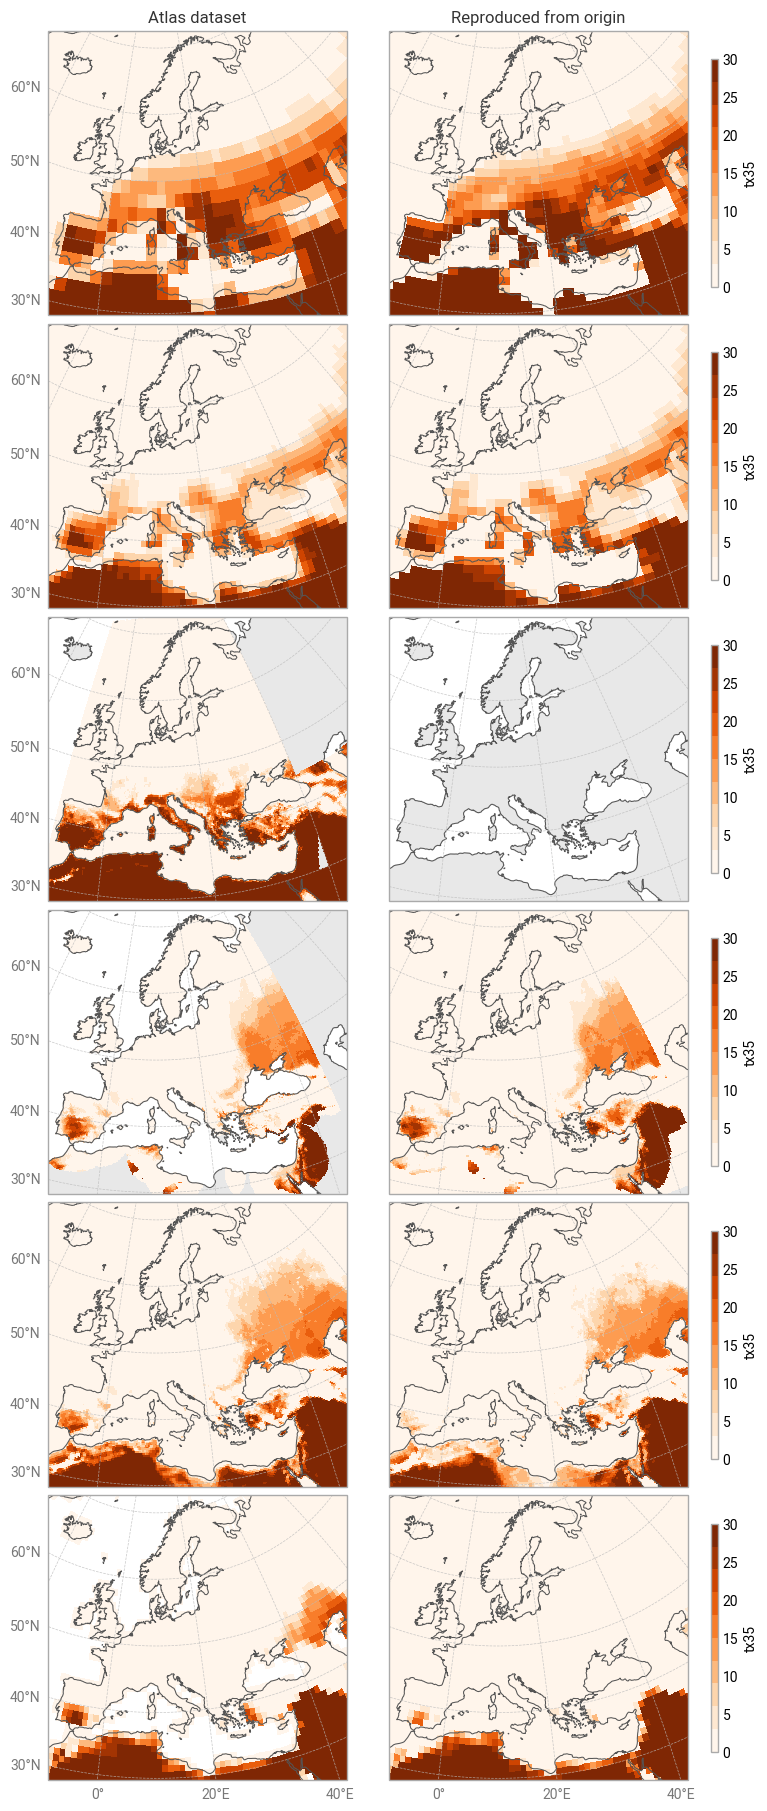

In [44]:
# partially work (fix above)
tx35_figs_by_key = geospatial_comparison_multiple_indicators(ds_atlas_origins_tx35, datasets_tx35_single_year, 
                                                             "tx35", 8, domain = "Europe")

For the overall comparison, we compare the distribution of indicator values across all pixels and months within each year.

#### Reproducibility: Comparison on Atlas grid

First, we recreate the geospatial comparison plots.
This time, because both datasets are on the same grid, 
this includes the 1-to-1 difference per pixel.

In [45]:
# this cell will contain the global plots for each dataset, 

For a quantitative measure of the differences between the Atlas dataset and the indicators reproduced from the origin dataset,
we perform a point-by-point comparison across the full spatial and temporal dimensions.

The point-by-point comparison can be summarised into the following metrics:

In [46]:
# this cell code to calculate metrics 

This will be an interpretation and analysis of the results 

## ℹ️ If you want to know more

### Key resources
The CDS catalogue entries for the data used were:
* Gridded dataset underpinning the Copernicus Interactive Climate Atlas: [multi-origin-c3s-atlas](https://doi.org/10.24381/cds.h35hb680)
  * [](./derived_multi-origin-c3s-atlas_consistency_q01)
  * [](./derived_multi-origin-c3s-atlas_consistency_q02)
  * [](./derived_multi-origin-c3s-atlas_consistency_q03)
* CMIP6 climate projections: [projections-cmip6](https://doi.org/10.24381/cds.c866074c)
  * [Quality assessments for CMIP6](../Climate_Projections/CMIP6/CMIP6.md)


Code libraries used:
* [earthkit](https://github.com/ecmwf/earthkit)
  * [earthkit-data](https://github.com/ecmwf/earthkit)
  * [earthkit-plots](https://github.com/ecmwf/earthkit-plots)
* [User-tools for the C3S Atlas](https://github.com/ecmwf-projects/c3s-atlas)
* [xclim](https://xclim.readthedocs.io/en/stable/) climate indicator tools


More about the Copernicus Interactive Climate Atlas and its IPCC predecessor:
* [Copernicus Interactive Climate Atlas application](https://atlas.climate.copernicus.eu/)
* [Gridded data underpinning the Copernicus Interactive Climate Atlas: Description of the datasets and variables](https://confluence.ecmwf.int/display/CKB/Gridded+data+underpinning+the+Copernicus+Interactive+Climate+Atlas%3A+Description+of+the+datasets+and+variables)
* [The Copernicus Interactive Climate Atlas: a tool to explore regional climate change](https://doi.org/10.21957/ah52ufc369)
* [Copernicus Interactive Climate Atlas: a new tool to visualise climate variability and change](https://www.ecmwf.int/en/newsletter/179/news/copernicus-interactive-climate-atlas-new-tool-visualise-climate-variability)
* [Implementation of FAIR principles in the IPCC: the WGI AR6 Atlas repository](https://doi.org/10.1038/s41597-022-01739-y)
* [Climate Change 2021 – The Physical Science Basis: Atlas](https://doi.org/10.1017/9781009157896.021)

### References
_To be replaced with numerical references once the text is finished_

[[Guti24](https://doi.org/10.21957/ah52ufc369)] J. M. Gutiérrez et al., ‘The Copernicus Interactive Climate Atlas: a tool to explore regional climate change’, ECMWF Newsletter, vol. 181, pp. 38–45, Oct. 2024, doi: 10.21957/ah52ufc369.

[[AtlasData](https://doi.org/10.24381/cds.h35hb680)] Copernicus Climate Change Service, ‘Gridded dataset underpinning the Copernicus Interactive Climate Atlas’. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), Jun. 17, 2024. doi: 10.24381/cds.h35hb680.

[[CMIP6data](https://doi.org/10.24381/cds.c866074c)] Copernicus Climate Change Service, ‘CMIP6 climate projections’. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), Mar. 23, 2021. doi: 10.24381/cds.c866074c.

[[Bur20](https://doi.org/10.1364/OE.391470)] O. Burggraaff, ‘Biases from incorrect reflectance convolution’, Optics Express, vol. 28, no. 9, pp. 13801–13816, Apr. 2020, doi: 10.1364/OE.391470.